<a href="https://colab.research.google.com/github/TienNguyen0712/credit-card-fraud-detection/blob/main/src/notebooks/02_preprocessing_and_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 **Preprocessing And Baseline Model (Tiền xử lý dữ liệu và Mô hình cốt lõi)**

> Mục tiêu: Lựa chọn các đặc trưng, thực hiện xử lý mất cân bằng dữ liệu, huấn luyện mô hình cơ sở

## ⚙️ **Preprocessing Data (Chuẩn bị dữ liệu)**

Việc xử lý dữ liệu mất cân bằng sẽ ngăn chặn việc mô hình sẽ học "lười" làm giảm độ chính xác của mô hình

### **Undersampling**

Cắt giảm số lượng mẫu của nhóm đa số để bằng với số lượng mẫu của nhóm

Xóa ngẫu nhiên các nhóm đa số cho đến khi tỷ lệ giữa hai nhóm là 50/50 hoặc một phần tỉ lệ mong muốn

### **Oversampling**

Làm tăng số lượng mẫu của nhóm thiểu số lên
- Random: Sao chép y hệt các mẫu cần tăng
- SMOTE: Tạo ra các điểm dữ liệu giả, nhưng trông giống thật bằng cách nối các điểm dữ liệu gian lận gân nhau và lấy một điểm nằm trên đoạn thằng đó

### **Class weight**

Gán cho các mẫu thiểu số một "hình phạt" nặng hơn khi mô hình đoán sai



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
df = pd.read_csv("df_cleaned.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,4.262539


## 🛃 **Split Data And Train (Chia dữ liệu và thực hiện xử lý mất cân bằng)**

### **Phương pháp đánh giá**

- **Precision - Recall** Curve:
Chỉ số Precsion và Recall đều tập chung vào các giao dịch gian lận được bắt chúng. Phản ánh trực tiếp khả năng tìm thấy só lượng nhỏ mà không bị rò ri thông tin
- **Confusion-Maxtrix:** Nhằm đánh giá trên tập dữ liệu có bao nhiêu giao dịch là đoán đúng là gian lận

### **Phương pháp chuẩn hóa**

- **RobustScaler:** Hoạt động dựa trên Trung vị và khoảng biến thiên tứ phân vị. Do dữ liệu có nhiều nhiều và giá trị ngoại lệ cực lớn

**Công thức**

$$x_{scaled} = \frac{x - \text{median}(x)}{Q_3(x) - Q_1(x)}$$



In [4]:
features = df.drop(columns=["Class", "Time", "Amount"])
target = df["Class"]

In [5]:
scaler = RobustScaler()
features['Amount_log'] = scaler.fit_transform(features['Amount_log'].values.reshape(-1, 1))

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)


### **Phương pháp 1: Sử dụng SMOTE kết hợp cùng mô hình cơ sở**

In [6]:
# Chỉ thực hiện SMOTE trên tập TRAIN
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Tỉ lệ sau SMOTE: {Counter(y_train_res)}")

# Huấn luyện mô hình trên dữ liệu đã cân bằng
model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_train_res, y_train_res)

y_pred_smote = model_smote.predict(X_test)
print("--- Kết quả với SMOTE ---")
print(classification_report(y_test, y_pred_smote))

Tỉ lệ sau SMOTE: Counter({0: 174146, 1: 174146})
--- Kết quả với SMOTE ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     43536
           1       0.08      0.93      0.15        95

    accuracy                           0.98     43631
   macro avg       0.54      0.95      0.57     43631
weighted avg       1.00      0.98      0.99     43631



**Nhận xét**
- **Lớp gian lận (1)**
  - **Recall = 0.93:** Mô hình nhận diện thành công 93% tổng số các vụ gian lận thực tế
  - **Precision = 0.08:** Trong tất cả các giao dịch mà mô hình gắn thẻ "gian lận" thì có 8% là thực sự gian lận
    - **Tức là** các phần còn lại là bảo động giả, khách hàng bình thường sẽ bị khóa thẻ nhầm lẫn rất nhiều
  - **F1-Score = 0.15:** Nất cân bằng giữa việc bắt đúng gian lân và việc không làm phiền khách hàng
- **Lớp không gian lận (0)**
  - Mô hình đạt độ chính xác gần như tuyệt đối cho các giao dịch hợp lệ. Tuy nhiên, chỉ số **Recall (0.98)** ở lớp 0 xác nhận lại vấn đề trên: có khoảng 2% giao dịch bình thường đang bị mô hình phân loại nhầm sang gian lận. Với khối lượng giao dịch ngân hàng khổng lồ, 2% này là một con số rất lớn về mặt số lượng tuyệt đối

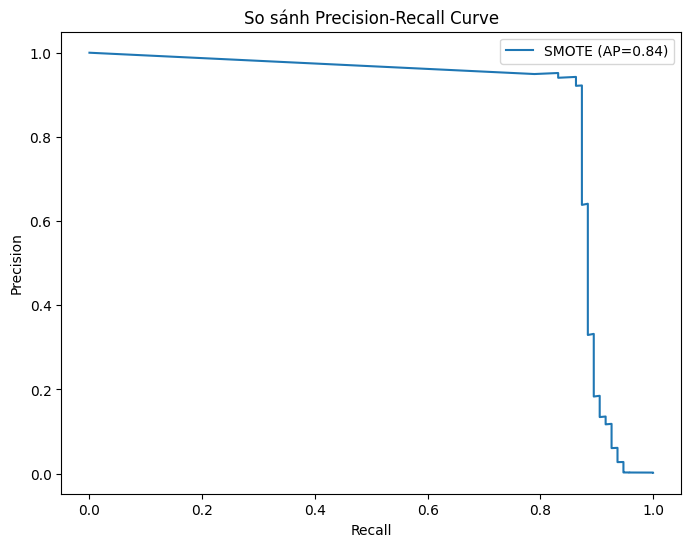

In [7]:
def plot_pr_curve(model, X_test, y_test, label):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.plot(recall, precision, label=f'{label} (AP={average_precision_score(y_test, y_probs):.2f})')

plt.figure(figsize=(8, 6))
plot_pr_curve(model_smote, X_test, y_test, "SMOTE")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('So sánh Precision-Recall Curve')
plt.legend()
plt.show()

**Nhận xét**

- **Chi số AP = 0.84**: Diện tích dưới đường cong PR, mô hình có khả năng phân loại rất tốt. SMOTE đã giup mô hình học đươc dặc trưng của các giao dịch thay vì dự đoán ngẫu nhiên

- **Dáng đường cong:** Ta có các đánh đổi được rút ra
  - **Recall từ 0 đến 0.82:** Duy trì mức Precision rất cao. Cho thất có thể bắt được 82% số vụ gian lận mã gần như không bị nhầm lẫn
  - **Diểm "gãy":** Sau điểm này sụt giảm mạnh
    - Cố gắng bắt thêm thì Precision sẽ giảm sâu. Hệ quả là khóa nhầm rất nhiều thẻ của khách hàng bình thường

**Đánh giá**

Nếu đưa mô hình này vào thực tế:

- Ngân hàng sẽ ngăn chặn được hầu hết các vụ thất thoát tiền bạc do gian lận

- Tuy nhiên cứ 100 người thì phải gọi để xác nhận có 92 người là trung thực. Rât tốn chi phí vận hành


### **Phương pháp 2: Sử dụng Class Weight với mô hình cơ sở**

In [8]:
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_cw.fit(X_train, y_train)

y_pred_cw = model_cw.predict(X_test)
print("--- Kết quả với Class Weight ---")
print(classification_report(y_test, y_pred_cw))

--- Kết quả với Class Weight ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     43536
           1       0.09      0.95      0.16        95

    accuracy                           0.98     43631
   macro avg       0.54      0.96      0.57     43631
weighted avg       1.00      0.98      0.99     43631



**Nhận xét**
- **Lớp gian lận (1)**
  - **Recall = 0.95:** Mô hình cũng đã nhận diện thành công 95% tổng số các vụ gian lận thực tế. Biết mặt "kẻ gian" tốt hơn SMOTE
  - **Presion = 0.09:** Trong số tất cả các giao dịch mà mô hình cho là "gian lận" thì có 9% thực sự là gian lận
    - Còn lại 91% là các báo động giả. Khách hàng bình thường sẽ bị khóa nhầm rất nhiều
  - **F1-Score = 0.16:** Mất cân bằng giữa việc bắt đúng gian lận và việc không làm phần khách hàng
- **Lớp không gian lận (0)**
  - Đạt độ chính xác gàn như tuyệt đối với giao dịch hợp lệ. Tuy nhiên **Recall = 0.98** cho thấy có khoảng 2% giao dịch bình thường đang bị mô hình phân loại sang gian lận

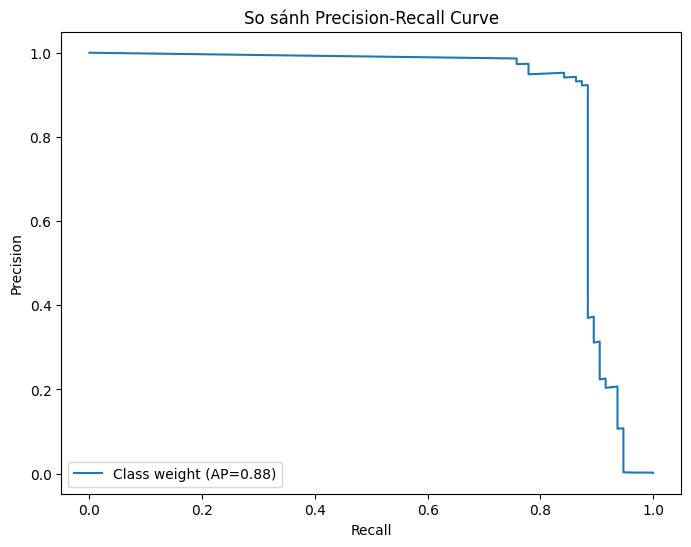

In [9]:
def plot_pr_curve(model, X_test, y_test, label):
    y_probs = model_cw.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.plot(recall, precision, label=f'{label} (AP={average_precision_score(y_test, y_probs):.2f})')

plt.figure(figsize=(8, 6))
plot_pr_curve(model_cw, X_test, y_test, "Class weight")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('So sánh Precision-Recall Curve')
plt.legend()
plt.show()

**Nhận xét**

- **Chi số AP = 0.88**: Diện tích dưới đường cong PR, mô hình có khả năng phân loại cực kỳ tốt. Class weight đã giup mô hình học đươc dặc trưng của các giao dịch thay vì dự đoán ngẫu nhiên

- **Dáng đường cong:** Ta có các đánh đổi được rút ra
  - **Recall từ 0 đến 0.82:** Duy trì mức Precision rất cao. Cho thấy có thể bắt được 82% số vụ gian lận mã gần như không bị nhầm lẫn
  - **Diểm "gãy":** Sau điểm này sụt giảm mạnh
    - Cố gắng bắt thêm thì Precision sẽ giảm sâu. Hệ quả là khóa nhầm rất nhiều thẻ của khách hàng bình thường



## 📈 **Conclusion (Kết luận)**

- Các chỉ số nhìn chung mô hình đã nhận diện được đặc điểm của các giao dịch gian lận. Tuy nhiên đa số đều là các báo động giả
- Không nên sử dụng ngưỡng mặc định. Thử nâng ngưỡng thì có thể kết quả sẽ thay đổi
- Ưu tiên class-weight: Vì có diện tích dưới đường cong tốt hơn, đồng thời không làm tăng kiến kích thước tập dữ liệu như SMOTE